- sampling occurs in the wet season (October - April)
- rainfall in the dry season (July - October) - prior to sampling

We're interested in the effect of rainfall on the population growth.
Assumes an exponential population growth $N_{t} = r_{t}N_{t-1} - c_{t}$

- Population growth in the first year is unknown
- $r_{t}$ is a function of rainfall.

Observation model is the same as before $y_{t}|N_{t} \sim \mathcal{N}(N_{t}, \sigma^{2})$

Growth rate $r_{t} = e^{\beta_{0} + \beta_{1}rain}$
Modelled as an exponential function to avoid negative values. An alternative we could consider modelling the square root of rainfall, in that case $r_{t} = (\beta_{0} + \beta_{1}rain)^{2}$


### Model specification
- $N_{t}|N_{t-1} \sim \mathcal{N}(r_{t}N_{t-1} - C_{t-1}, \sigma_{N}^{2})$
- $log(r_{t}) = \beta_{0} + \beta_{1}Rain_{t}$
- $y_{t}|N_{t} \sim \mathcal{N}(N_{t}, \sigma_{y}^{2})$

### Priors 
- $\beta_{0}$, $\beta_{1}$
- $\sigma_{N}$, $\sigma_{y}$

We will consider priors for $\beta_{0}$ and $\beta_{1}$, where $\beta_{0}$ represents the intercept of the GLM considered for the growth rate as a function of rain and $\beta_{1}$ the slope of the linear model. We will model the log of the growth rate, in order to avoid having a growth rate negative. An alternative for this model is to model the square root of the growth rate (with the power link function) instead of the exponential. This model would make sure as well that the growth rate will always take positive values. 

Because we don't have any prior knowledge of what suitable values for $\beta_{0}$ and $\beta_{1}$ should be considered, we will use uninformative priors. 
One solution is to consider priors modeled as a Uniform distribution, Uniform(0, $T$) with $T$ large, to account for a high range of possible values, equally probable. The problem with choosing a Uniform distribution on this range would be that this would consider values in interval (0, $T$) and this would be too restrictive for $\beta_{0}$ and $\beta_{1}$. To fix this we could consider a Uniform on ($-T$, $T$) that could sample negative values as well. An alternative is to consider a Normal distribution with a very low precision (or very high variance), such as $\mathcal{N}(0, \tau=0.00001)$ where $\tau$ is the precision. Further alternatives for setting the priors would be to consider prior elicitation using an expert in the domain or to consider a hierarchical model where $T$ or $\tau$ (or $\sigma$) could be further modeled as random variables rather than fixed constants. For the purpose of this modelling we would consider:

- $\beta_{0} \sim \mathcal{N}(0, \tau=0.00001)$
- $\beta_{1} \sim \mathcal{N}(0, \tau=0.00001)$

Additionally, we need to consider priors for $\sigma_{N}$ and $\sigma_{y}$. In this case we need to consider distributions only on the positive range (because standard deviation cannot take negative values), and to account for the lack of knowledge of what these parameters could be, we will use uninformative priors as well. A range of possible solutions are as follows: 

- Truncated Normal distribution
- LogNormal distribution
- Gamma (a very uninformative Gamma could be $\sim Gamma(\alpha=0.00001, \beta=0.00001)$)
- Uniform (0, $T$) with T positive. 

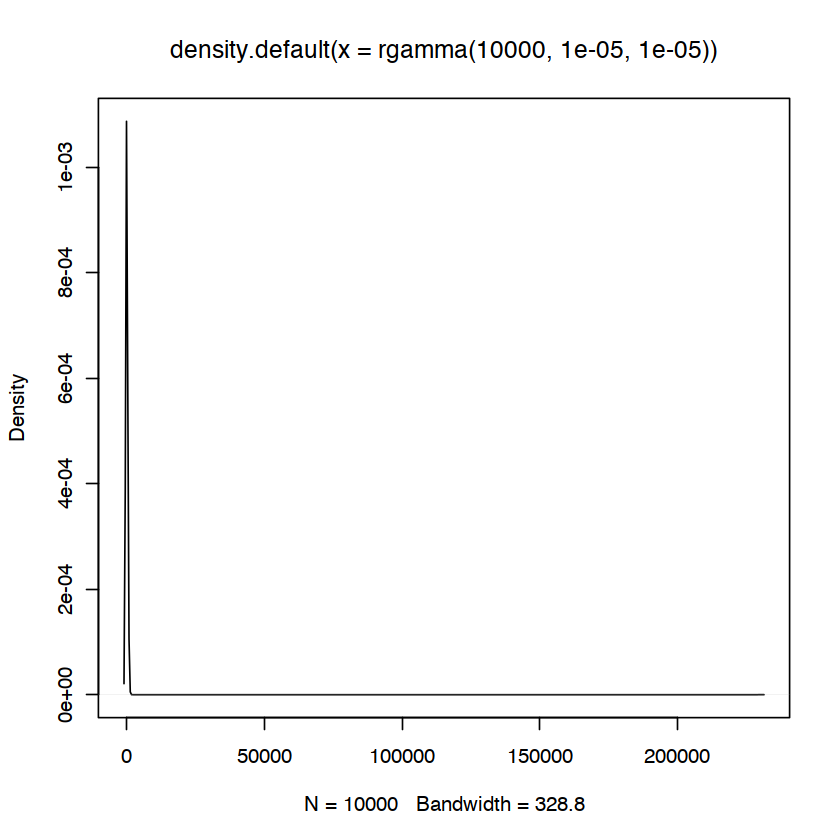

In [9]:
plot(density(rgamma(10000, 0.00001, 0.00001)))